# **Malaria Detection**

##<b>Problem Definition</b>
**The context:** Why is this problem important to solve?<br>

This problem is important to solve since malaria is a disease that affects millions each year, many with resulting death.

Having a system that can detect malaria early and fastly can reduce mortality and therefore save many lives.

**The objectives:** What is the intended goal?<br>

The intended goal is to develop an deep learning model to detect parasitized cells from microscopic images

**The key questions:** What are the key questions that need to be answered?<br>

The key questions that need to be answer are:

- How does the data look and what kind of transformations need to be done in order to work with it?

- Which model architecture is best suited for this data?

- And what measurements are we going to use in order to get such model?

**The problem formulation:** What is it that we are trying to solve using data science?

Simply put, we are trying to generate a deep learning model that classifies images microscopic images from cells into parasitized or uninfected, which implies that the organisms has malaria.

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### <b>Loading libraries</b>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback


import zipfile
import cv2
import os
import random

from PIL import Image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [ ]:
print("Tensorflow version " + tf.__version__)

#try:
#  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
#except ValueError:
#  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.12.0


### <b>Let us load the data</b>

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

for f in zip_ref.namelist():
    zinfo = zip_ref.getinfo(f)
    if(zinfo.is_dir()):
        print(f)

cell_images/test/
cell_images/test/parasitized/
cell_images/test/uninfected/
cell_images/train/
cell_images/train/parasitized/
cell_images/train/uninfected/


In [ ]:
# I define a function to extract data from each directory, as an image of a given size

def get_data(dir, status, size):
  images = []
  labels = []

  for x in os.listdir(dir):
    path = dir + x
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, (size,size))
    images.append(np.array(img))
    labels.append(status)

  return images, labels


The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [ ]:
#Image size parameter

size = 80

In [ ]:
train_1, label_1 = get_data('/content/cell_images/train/parasitized/', 1, size)
train_2, label_2 = get_data('/content/cell_images/train/uninfected/', 0, size)


train_images = np.array(train_1 + train_2)
train_labels = np.array(label_1+label_2)

test_1, tlabel_1 = get_data('/content/cell_images/test/parasitized/', 1, size)
test_2, tlabel_2 = get_data('/content/cell_images/test/uninfected/', 0, size)


test_images = np.array(test_1+ test_2)
test_labels = np.array(tlabel_1+tlabel_2)

In [ ]:
del train_1
del train_2
del test_1
del test_2
del label_1
del label_2
del tlabel_1
del tlabel_2

In [ ]:
print('Shape of train data:', train_images.shape)
print('Shape of train label data:', train_labels.shape)
print('Shape of test data:', test_images.shape)
print('Shape of test label data:', test_labels.shape)

Shape of train data: (24958, 80, 80, 3)
Shape of train label data: (24958,)
Shape of test data: (2600, 80, 80, 3)
Shape of test label data: (2600,)


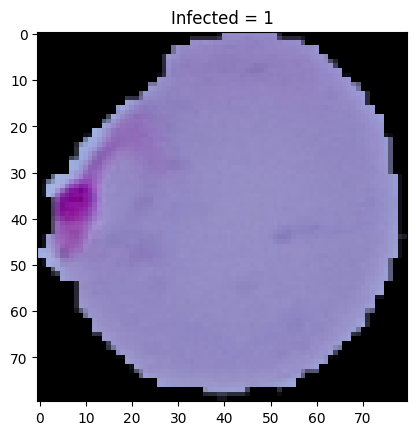

In [ ]:
#Lets see how this images look;

plt.imshow(train_images[1050], interpolation='nearest')
plt.title('Infected = ' + str(train_labels[1050]))
plt.show()


###<b> Check the shape of train and test images

In [ ]:
print('Shape of train images: ', train_images[0].shape)
print('Shape of test images: ',test_images[0].shape)

Shape of train images:  (80, 80, 3)
Shape of test images:  (80, 80, 3)


###<b> Check the shape of train and test labels

In [ ]:
print(train_labels[1])
print(test_labels[1])

1
1


####<b> Observations and insights:</b>



The data is ready to be manipulated.


### <b>Check the minimum and maximum range of pixel values for train and test images

In [ ]:
print('Max pixel value for train data:', train_images.max())
print('Min pixel value for train data:',  train_images.min())
print('Max pixel value for test data:', test_images.max())
print('Min pixel value for test data:', train_images.min())


Max pixel value for train data: 255
Min pixel value for train data: 0
Max pixel value for test data: 255
Min pixel value for test data: 0


####<b> Observations and insights:</b>

Everithing seems fine.


###<b> Count the number of values in both uninfected and parasitized

In [ ]:
print('Number of parasitized in train data:',len(train_labels[train_labels==1]))
print('Number of uninfected in train data:',len(train_labels[train_labels==0]))
print('Number of parasitized in test data:',len(test_labels[test_labels==1]))
print('Number of uninfected in test data:', len(test_labels[test_labels==0]))

Number of parasitized in train data: 12582
Number of uninfected in train data: 12376
Number of parasitized in test data: 1300
Number of uninfected in test data: 1300


###<b>Normalize the images

In [ ]:
x_train_normalized = train_images/255
x_test_normalized = test_images/255

####<b> Observations and insights: _____

###<b> Plot to check if the data is balanced

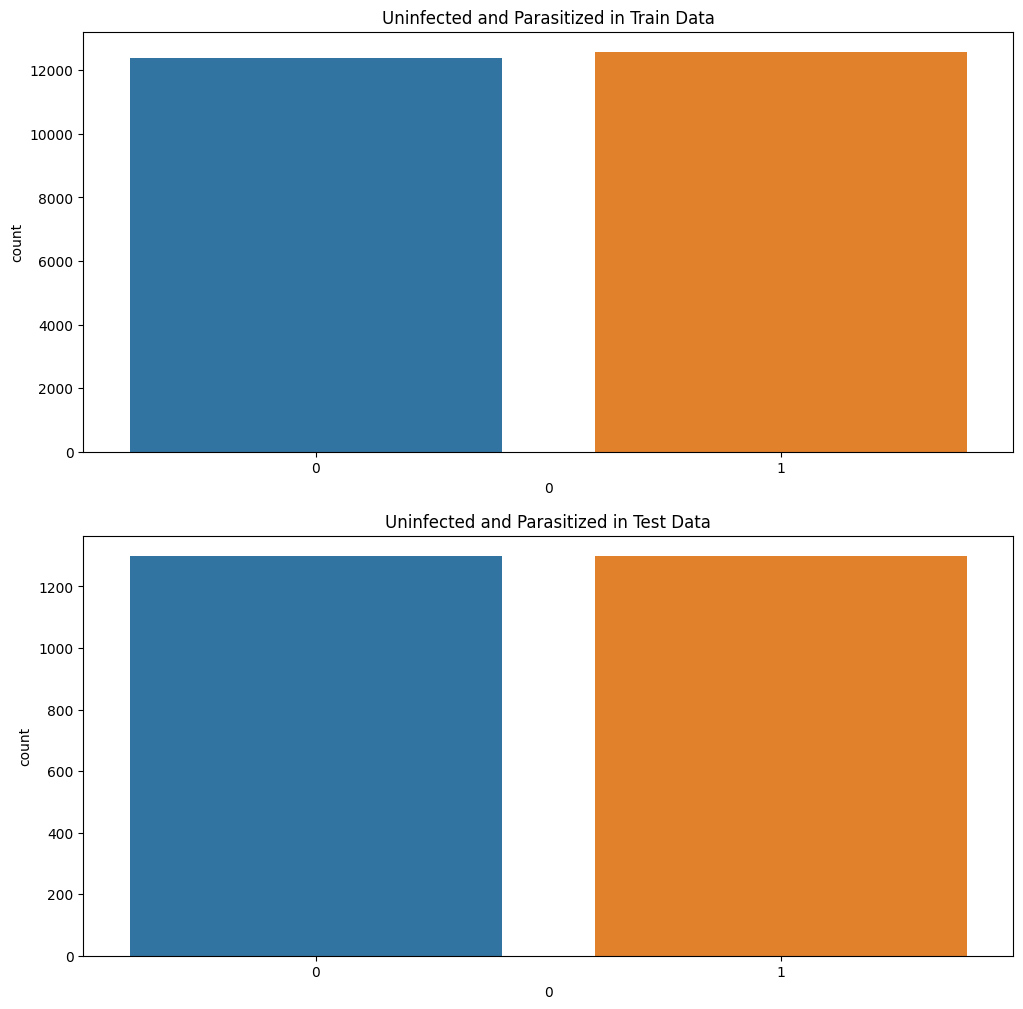

Values for train data:
 1    12582
0    12376
dtype: int64
Values for test data:
 0    1300
1    1300
dtype: int64


In [ ]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(2,1,1)
ax.set_title('Uninfected and Parasitized in Train Data')
aux1 = pd.DataFrame(train_labels)
sns.countplot(aux1, x = 0,ax = ax)

ax = fig.add_subplot(2,1,2)
ax.set_title('Uninfected and Parasitized in Test Data')
aux2 = pd.DataFrame(test_labels)
sns.countplot(aux2, x = 0,ax = ax)
plt.show()


print('Values for train data:\n', aux1.value_counts())
print('Values for test data:\n',aux2.value_counts())


####<b> Observations and insights:</b>

It looks like the data is balanced.

### <b>Data Exploration</b>
Let's visualize the images from the train data

In [ ]:
#I create a function to visualize the images since I'm going to use it later.
#It takes x= image data, y = label date, number of rows and cols, and the indexes to be shown

def plot_data(x,y, rows, cols, k):

  fig = plt.figure(figsize = (12, 12))

  for i in range(cols):
      for j in range(rows):
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)
          ax.imshow(x[k[i * rows + j ]])
          ax.set_title('Infected = ' + str(y[k[ i * rows + j ]]) + '\n Obs #:' + str(k[ i * rows + j ]))

  plt.show()

In [ ]:
#Here I choose random indexes for train and test data. I compute them because later
#I would like to seee what happens to the same images under some transformations

np.random.seed(37)
rows = 6
cols = 6

k1 = []
k2 = []
for x in range(36):
  k1.append(np.random.randint(train_images.shape[0]))
  k2.append(np.random.randint(test_images.shape[0]))

####<b> Observations and insights: _____

###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

Train Data


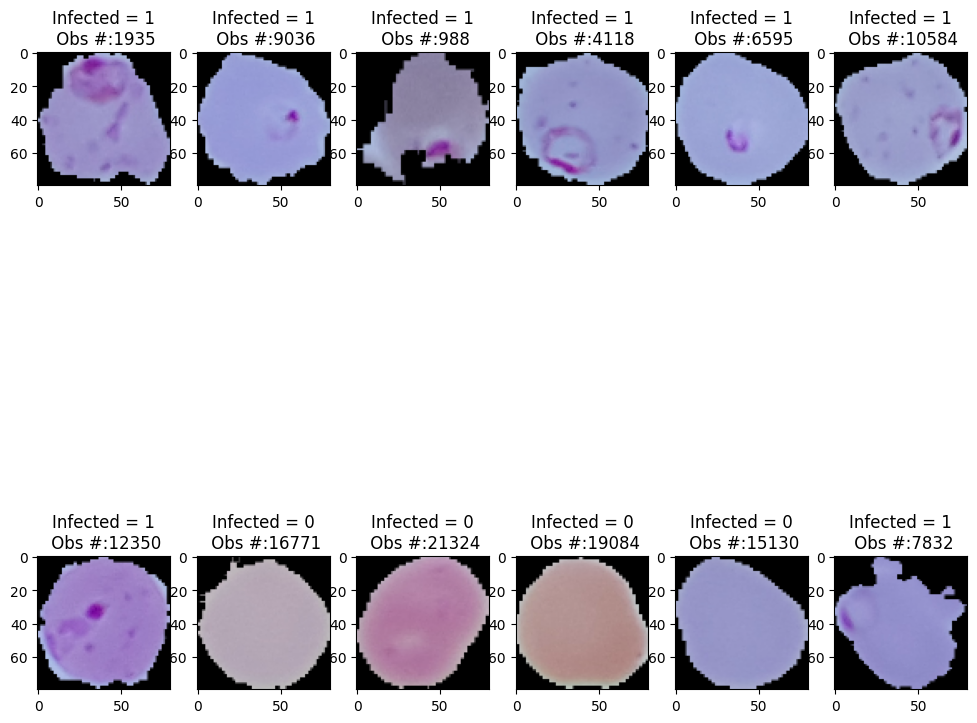

In [ ]:
print('Train Data')
plot_data(train_images, train_labels, rows, cols, k1)



Test Data


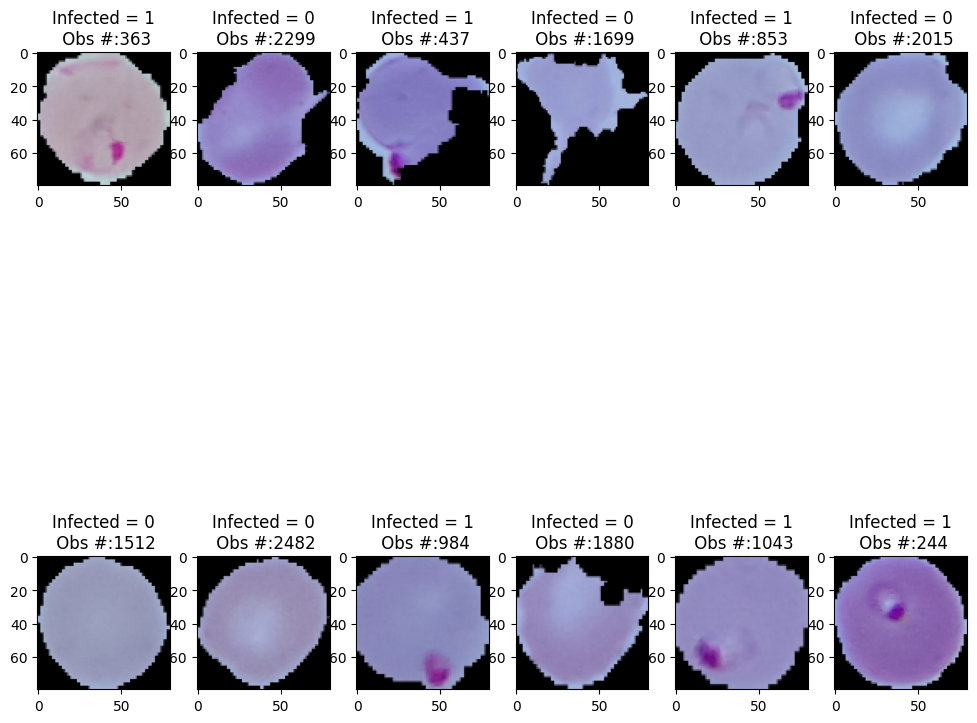

In [ ]:
print('Test Data')
plot_data(test_images, test_labels, rows, cols, k2)

####<b>Observations and insights:</b>

It looks like infected cells have some areas tinted that differentiate them.

###<b> Plotting the mean images for parasitized and uninfected

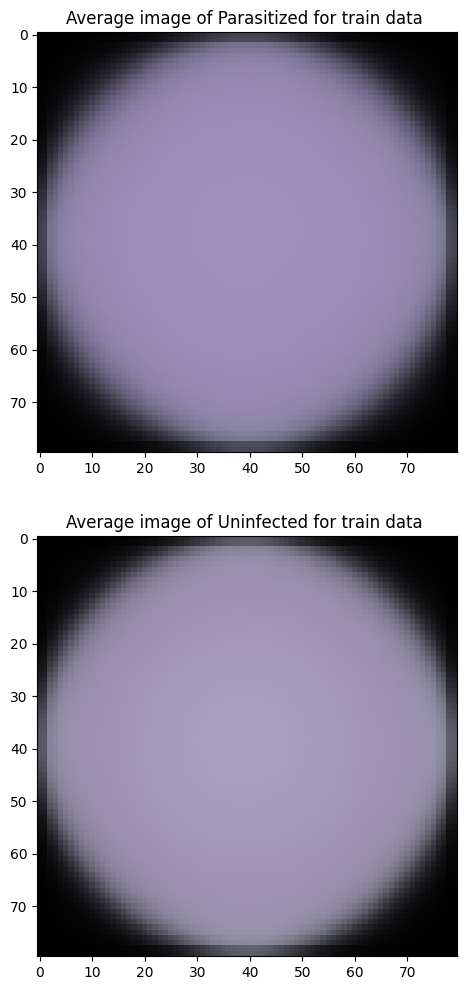

In [ ]:
aux1 = np.rint(np.mean(train_images[train_labels == 1], axis = 0)).astype(int)
aux0 = np.rint(np.mean(train_images[train_labels == 0], axis = 0)).astype(int)

fig = plt.figure(figsize = (12, 12))

ax = fig.add_subplot(2, 1, 1)
ax.imshow(aux1)
ax.set_title('Average image of Parasitized for train data ')

ax = fig.add_subplot(2, 1, 2)
ax.imshow(aux0)
ax.set_title('Average image of Uninfected for train data ')

plt.show()

####<b> Observations and insights:</b>

Both images look very similar, with the average for infected a little darker.

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

In [ ]:
train_hgv = np.empty((train_images.shape[0], size,size,3), dtype=int)

for x in range(train_images.shape[0]):
  train_hgv[x] = cv2.cvtColor(train_images[x], cv2.COLOR_RGB2HSV)

###<b> Converting the test data

In [ ]:
test_hgv = np.empty((test_images.shape[0], size,size,3), dtype=int)

for x in range(test_images.shape[0]):
  test_hgv[x] = cv2.cvtColor(test_images[x], cv2.COLOR_RGB2HSV)

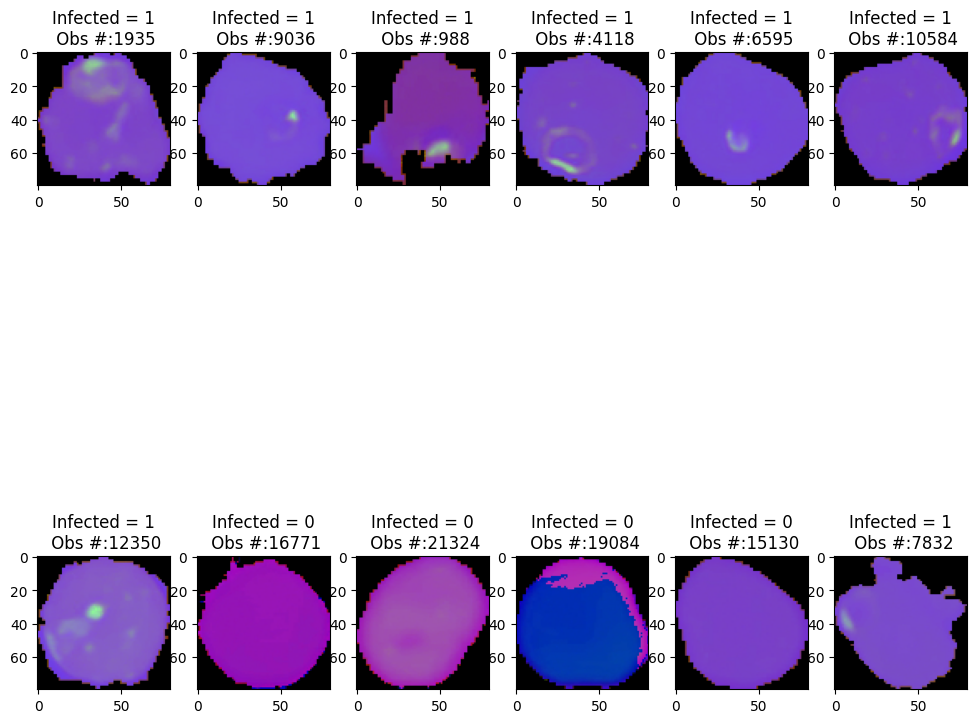

In [ ]:
plot_data(train_hgv, train_labels, rows, cols,k1)

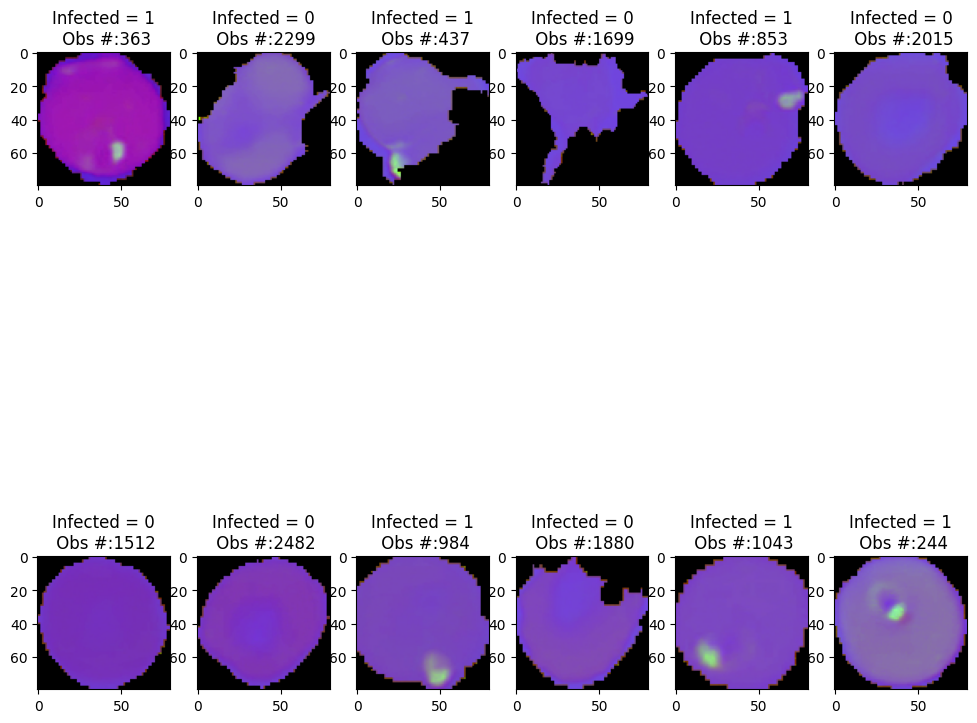

In [ ]:
plot_data(test_hgv, test_labels, rows, cols, k2)

In [ ]:
del train_hgv
del test_hgv

#I am liberating some memory

####<b>Observations and insights:</b>

- It seems like there is always some 'green' spot inthe infected cells. The contrast is very good, it might be a good idea to use this for the deep learning model.






###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

In [ ]:
train_blurred = np.empty((train_images.shape[0], size,size,3), dtype=int)

for x in range(train_images.shape[0]):
  train_blurred[x] = cv2.GaussianBlur(train_images[x], (5,5),0)

###<b> Gaussian Blurring on test data

In [ ]:
test_blurred = np.empty((test_images.shape[0], size,size,3), dtype=int)

for x in range(test_images.shape[0]):
  test_blurred[x] = cv2.GaussianBlur(test_images[x], (5,5),0)

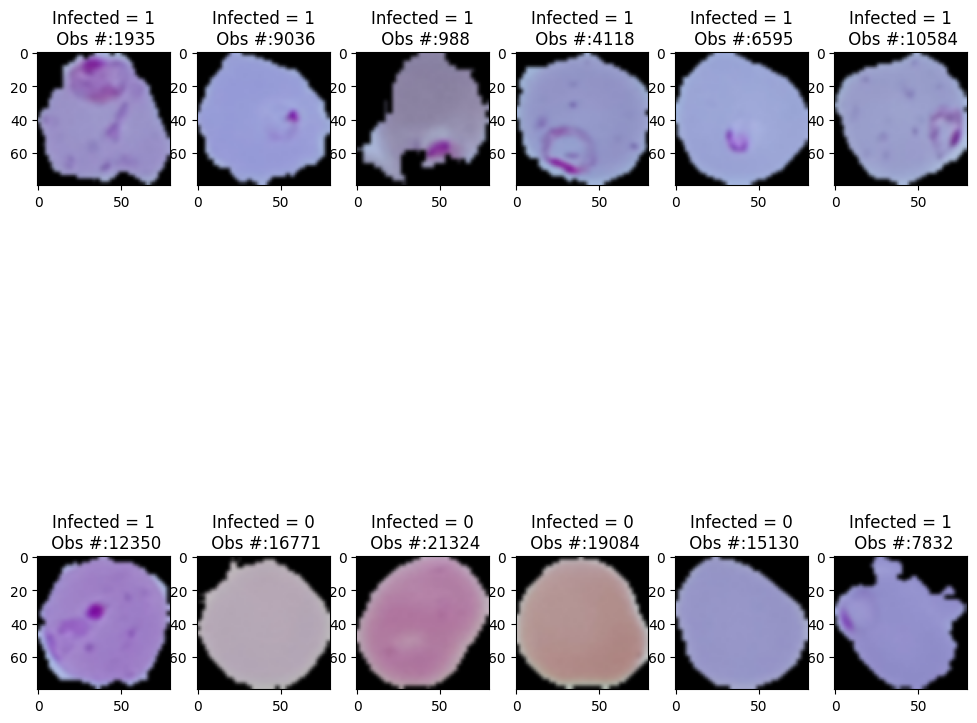

In [ ]:
plot_data(train_blurred, train_labels, rows, cols, k1)

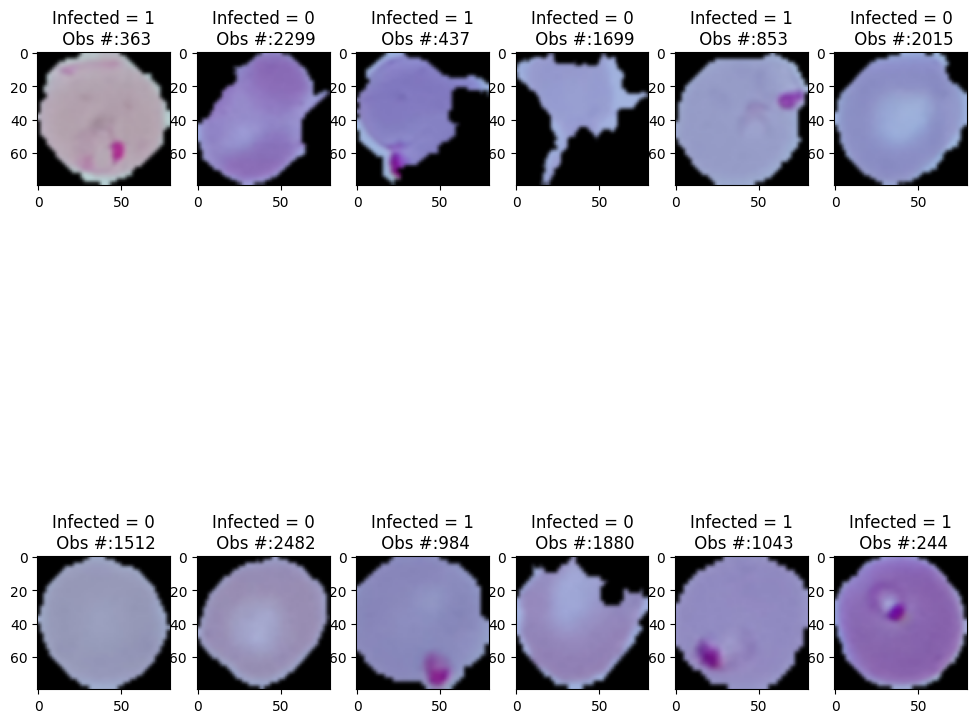

In [ ]:
plot_data(test_blurred, test_labels, rows, cols, k2)

In [ ]:
del train_blurred
del test_blurred

#liberating some memory

####**Observations and insights:**

Gaussian blurring removes noise from images. It can help if we are sure that is a problem. However, we don't know wich kernel / signma to use, and using a gaussian blur with fixed might be dominated by using a gaussian filter in the CNN.  

For this particular problem it seems that it won't be very helpful.

## **Model Building**

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [ ]:
#imported at the beginning

#parameters for the models
epoch = 15
val = 0.2
batch = 300



####<B>One Hot Encoding the train and test labels

In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(train_labels,2)
y_test_encoded = tf.keras.utils.to_categorical(test_labels,2)

###<b> Building the model

In [ ]:
np.random.seed(37)
random.seed(37)
tf.random.set_seed(37)

In [ ]:
def model_1():
  model = Sequential()
  model.add(Conv2D(filters = 16, kernel_size = 5, padding = "same", input_shape = (size, size, 3), activation= 'relu'))
  model.add(MaxPooling2D(pool_size = 2))

  model.add(Flatten())
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(2, activation = 'softmax'))

  model.compile(

    loss = 'binary_crossentropy',

    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),

    metrics=['accuracy']
    )


  return model




In [ ]:
model_1 = model_1()
print(model_1.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 32)                819232    
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 820,514
Trainable params: 820,514
Non-trainable params: 0
__________________________________________________

<b> Fit and train our Model

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)


In [ ]:
history_1 = model_1.fit(
            x_train_normalized, y_train_encoded,
            epochs = epoch,
            validation_split = val,
            shuffle = True,
            batch_size=batch,
            use_multiprocessing = True,
            callbacks = [es, mc]
)

Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.5984
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model.h5
67/67 [==============================] - 6s 27ms/step - loss: 0.6844 - accuracy: 0.5984 - val_loss: 0.9430 - val_accuracy: 0.0000e+00
Epoch 2/15
66/67 [============================>.] - ETA: 0s - loss: 0.6022 - accuracy: 0.6332
Epoch 2: val_accuracy improved from 0.00000 to 0.15986, saving model to best_model.h5
67/67 [==============================] - 1s 14ms/step - loss: 0.6021 - accuracy: 0.6335 - val_loss: 0.9880 - val_accuracy: 0.1599
Epoch 3/15
66/67 [============================>.] - ETA: 0s - loss: 0.5851 - accuracy: 0.6871
Epoch 3: val_accuracy improved from 0.15986 to 0.20413, saving model to best_model.h5
67/67 [==============================] - 1s 14ms/step - loss: 0.5850 - accuracy: 0.6873 - val_loss: 0.9396 - val_accuracy: 0.2041
Epoch 4/15
66/67 [============================>.] - ETA: 0s - loss: 0

###<b> Evaluating the model on test data

In [ ]:
#I create functions to look at the performance of the models

def evaltest(x_test, model):
  y_pred_test = model.predict(x_test)
  y_pred_test_classes = np.argmax(y_pred_test, axis = 1)
  y_pred_test_max_probas = np.max(y_pred_test, axis = 1)
  return y_pred_test, y_pred_test_classes, y_pred_test_max_probas

def class_conf(y_test, y_pred):
  print(classification_report(y_test, y_pred))

  # Plotting the heatmap using confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize = (8, 5))
  sns.heatmap(cm, annot = True,  fmt = '.0f')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')


  plt.show()

def trainvalcurve(history_1):
  plt.plot(history_1.history['accuracy'])
  plt.plot(history_1.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'upper left')

  plt.show()

In [ ]:
y_pred_test, y_pred_test_classes, y_pred_test_max_probas = evaltest(x_test_normalized, model_1)

82/82 [==============================] - 0s 2ms/step


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.78      0.48      0.60      1300
           1       0.63      0.87      0.73      1300

    accuracy                           0.67      2600
   macro avg       0.70      0.67      0.66      2600
weighted avg       0.70      0.67      0.66      2600



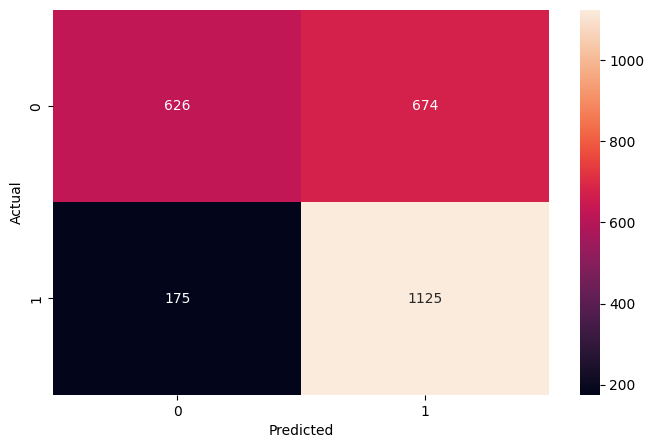

In [ ]:
class_conf(test_labels, y_pred_test_classes)

<b>Plotting the train and validation curves

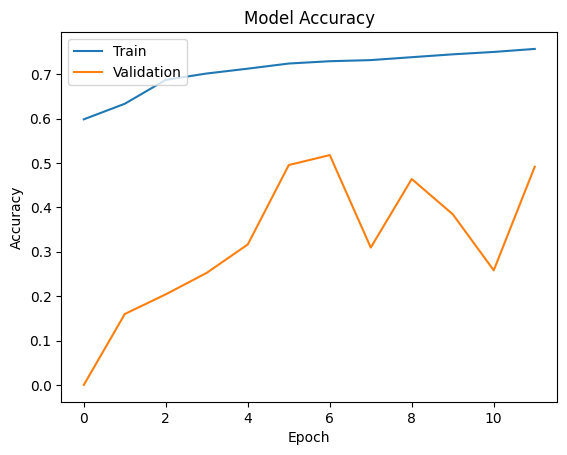

In [ ]:
trainvalcurve(history_1)

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [ ]:
backend.clear_session()

np.random.seed(37)
random.seed(37)
tf.random.set_seed(37)

###<b> Building the Model

In [ ]:
def model_2():
  model = Sequential()
  model.add(Conv2D(filters = 16, kernel_size = 3, padding = "same", input_shape = (size, size, 3), activation= 'relu'))
  model.add(MaxPooling2D(pool_size = 2))

  model.add(Conv2D(filters = 32, kernel_size = 5, padding = 'same', activation= 'sigmoid'))
  model.add(MaxPooling2D(pool_size = 2))

  model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation= 'relu'))
  model.add(MaxPooling2D(pool_size = 2))

  model.add(Flatten())
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(2, activation = 'softmax'))

  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
    metrics=['accuracy']
    )


  return model

###<b> Compiling the model

In [ ]:
model_2 = model_2()
print(model_2.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0

<b> Using Callbacks

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

<b>Fit and Train the model

In [ ]:
history_2 = model_2.fit(
            x_train_normalized, y_train_encoded,
            epochs = epoch,
            validation_split = val,
            shuffle = True,
            batch_size=batch,
            use_multiprocessing = True,
            callbacks = [es, mc]
)

Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 0.6628 - accuracy: 0.6268
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model.h5
67/67 [==============================] - 4s 32ms/step - loss: 0.6628 - accuracy: 0.6268 - val_loss: 0.9881 - val_accuracy: 0.0000e+00
Epoch 2/15
65/67 [============================>.] - ETA: 0s - loss: 0.6371 - accuracy: 0.6298
Epoch 2: val_accuracy did not improve from 0.00000
67/67 [==============================] - 1s 16ms/step - loss: 0.6367 - accuracy: 0.6302 - val_loss: 0.9856 - val_accuracy: 0.0000e+00
Epoch 3/15
66/67 [============================>.] - ETA: 0s - loss: 0.6136 - accuracy: 0.6480
Epoch 3: val_accuracy improved from 0.00000 to 0.49439, saving model to best_model.h5
67/67 [==============================] - 1s 16ms/step - loss: 0.6136 - accuracy: 0.6478 - val_loss: 0.8194 - val_accuracy: 0.4944
Epoch 4/15
65/67 [============================>.] - ETA: 0s - loss: 0.5979 - accuracy: 0.6789
Epoch 

###<b> Evaluating the model

In [ ]:
y_pred_test, y_pred_test_classes, y_pred_test_max_probas = evaltest(x_test_normalized, model_2)

82/82 [==============================] - 0s 3ms/step


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.87      0.62      0.72      1300
           1       0.70      0.91      0.79      1300

    accuracy                           0.76      2600
   macro avg       0.79      0.76      0.76      2600
weighted avg       0.79      0.76      0.76      2600



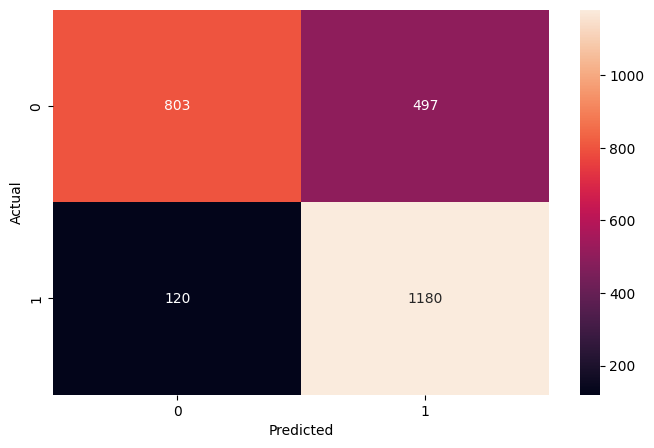

In [ ]:
class_conf(test_labels, y_pred_test_classes)

<b> Plotting the train and the validation curves

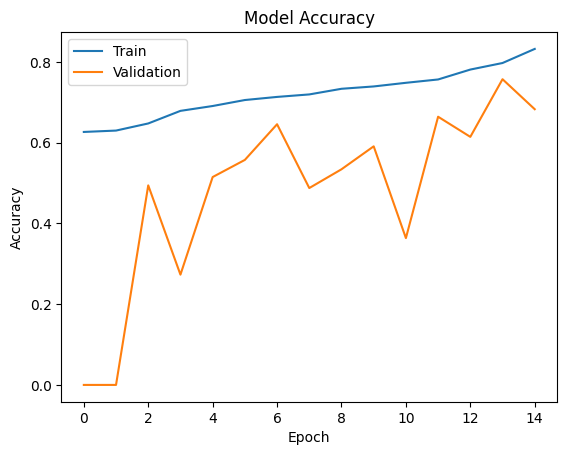

In [ ]:
trainvalcurve(history_2)

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [ ]:
backend.clear_session()

np.random.seed(37)
random.seed(37)
tf.random.set_seed(37)

###<b> Building the Model

In [ ]:
def model_3():
  model = Sequential()
  model.add(Conv2D(filters = 16, kernel_size = 3, padding = "same", input_shape = (size, size, 3)))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))

  model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same'))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.3))

  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(2, activation = 'softmax'))

  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
    metrics=['accuracy']
    )


  return model

###<b>Compiling the model

In [ ]:
model_3 = model_3()
print(model_3.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 16)        448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 40, 40, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                    

<b> Using callbacks

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)

<b>Fit and train the model

In [ ]:
history_3 = model_3.fit(
            x_train_normalized, y_train_encoded,
            epochs = epoch,
            validation_split = val,
            shuffle = True,
            batch_size=batch,
            use_multiprocessing = True,
            callbacks = [es, mc]
)

Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.6246
Epoch 1: val_loss improved from inf to 0.69490, saving model to best_model.h5
67/67 [==============================] - 5s 33ms/step - loss: 0.6644 - accuracy: 0.6246 - val_loss: 0.6949 - val_accuracy: 6.0096e-04
Epoch 2/15
65/67 [============================>.] - ETA: 0s - loss: 0.5890 - accuracy: 0.6378
Epoch 2: val_loss improved from 0.69490 to 0.69244, saving model to best_model.h5
67/67 [==============================] - 1s 18ms/step - loss: 0.5884 - accuracy: 0.6387 - val_loss: 0.6924 - val_accuracy: 0.9776
Epoch 3/15
65/67 [============================>.] - ETA: 0s - loss: 0.5537 - accuracy: 0.7034
Epoch 3: val_loss improved from 0.69244 to 0.68739, saving model to best_model.h5
67/67 [==============================] - 1s 18ms/step - loss: 0.5536 - accuracy: 0.7031 - val_loss: 0.6874 - val_accuracy: 0.9894
Epoch 4/15
67/67 [==============================] - ETA: 0s - loss: 0.4615 - accur

<b>Plotting the train and validation accuracy

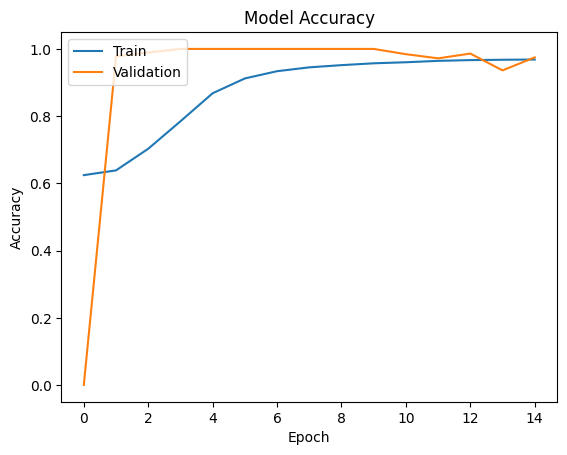

In [ ]:
trainvalcurve(history_3)


###<b>Evaluating the model

In [ ]:
y_pred_test, y_pred_test_classes, y_pred_test_max_probas = evaltest(x_test_normalized, model_3)

82/82 [==============================] - 0s 3ms/step


####<b>Observations and insights:</b>

This model is performing realy good, and the accuracy seems to be converging.

<b> Generate the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1300
           1       0.96      0.97      0.97      1300

    accuracy                           0.97      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.97      0.97      0.97      2600



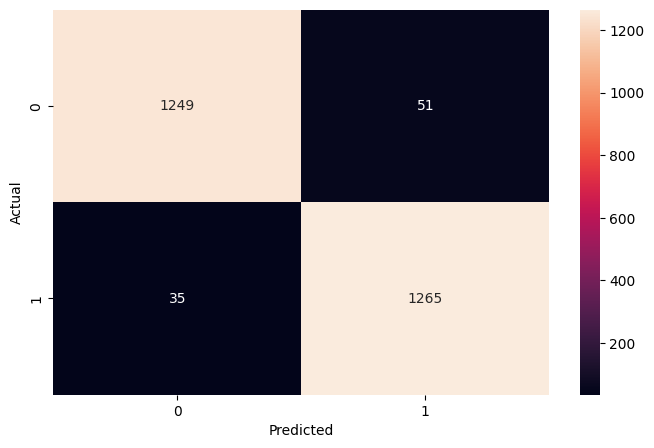

In [ ]:
class_conf(test_labels, y_pred_test_classes)

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [ ]:
backend.clear_session()

from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.layers import RandomCrop, RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast
from sklearn.model_selection import train_test_split

np.random.seed(37)
random.seed(37)
tf.random.set_seed(37)

x_train, x_val, y_train, y_val = train_test_split(train_images, y_train_encoded, test_size = val)

train_datagen = ImageDataGenerator( rotation_range=90, horizontal_flip=True )
#vertical and horizontal movement, and zoom do not produce good results. It probably has to do with the nature of the images.
val_datagen =ImageDataGenerator()



###<b> Use image data generator

In [ ]:
it1 = train_datagen.flow(x_train, y_train, batch_size=100, seed = 37, shuffle = True)
it2 = val_datagen.flow(x_val, y_val, batch_size=100, seed = 37, shuffle = True)

###**Comments :**<br>

*  I tried different parameters for the data generator. For example, I tried including vertical and horizontal movements, and zoom. However the performance got worse. I think it has to do with the photos coming from a controlled environment, and therefore being standarized in some sense.  



####<B>Visualizing Augmented images

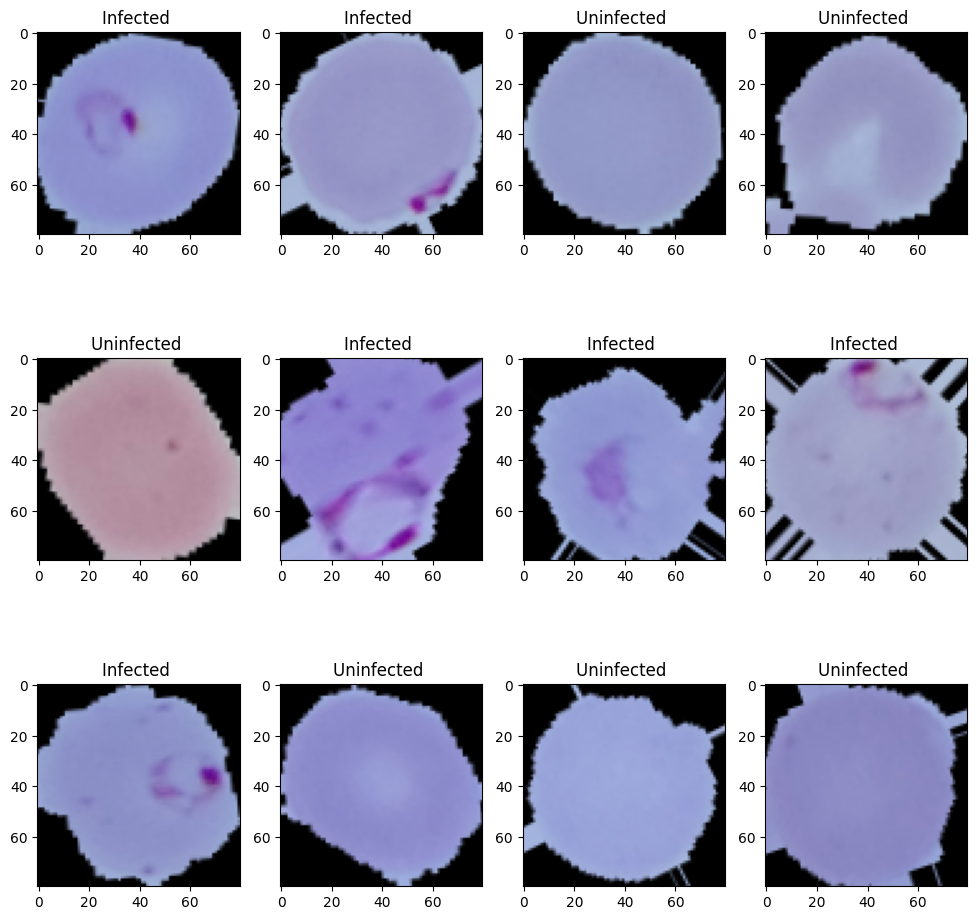

In [ ]:
images, infected = next(it1)

cols2 = 4
rows2 = 3

fig = plt.figure(figsize = (12, 12))

for i in range(cols2):
      for j in range(rows2):
          ax = fig.add_subplot(rows2, cols2, i * rows2 + j + 1)
          ax.imshow(images[i*rows2 + j].astype('uint8'))
          if infected[i*rows2 + j,1] ==1:
            ax.set_title('Infected ')
          else:
            ax.set_title('Uninfected ')

plt.show()

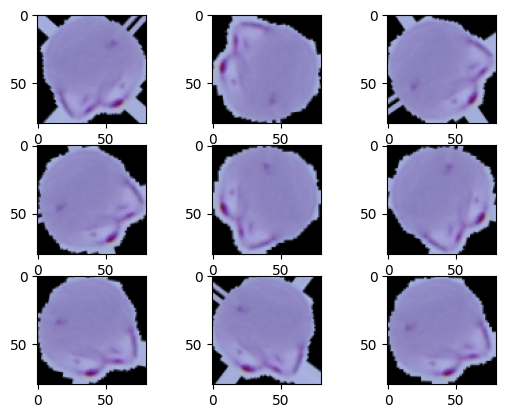

In [ ]:

#Now lets see what happens for the same images, how this is transforming it

aux =  x_train[86]

samples = np.expand_dims(aux, 0)

# prepare iterator
it = train_datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
 # define subplot
 plt.subplot(330 + 1 + i)
 # generate batch of images
 aux0 = it.next()
 # convert to unsigned integers for viewing
 image = aux0[0].astype('uint8')
 # plot raw pixel data
 plt.imshow(image)
# show the figure
plt.show()


####<b>Observations and insights:</b>

* From the pictures, we observe different transformations of the images. When rotated, some space needs to be filled. That creates the lines that are shown in some images.



###<b>Building the Model

In [ ]:
#This is the same model as before, since it performs so well.

def model_4():
  model = Sequential()
  model.add(Conv2D(filters = 16, kernel_size = 3, padding = "same", input_shape = (size, size, 3)))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))

  model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same'))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))

  model.add(Dropout(0.3))

  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(2, activation = 'softmax'))

  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
    metrics=['accuracy']
    )


  return model



In [ ]:
model_4 = model_4()
print(model_4.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 16)        448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 40, 40, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                    

<b>Using Callbacks

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)


<b> Fit and Train the model

In [ ]:
history_4 = model_4.fit(
            it1,
            validation_data = it2,
            epochs = epoch,
            batch_size=batch,
            steps_per_epoch=150,
            callbacks = [es, mc]
)

#This has different parameters than our previous models.For example, the validation data is a generator
# and we need to specify steps per epoch.

Epoch 1/15
150/150 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.6801
Epoch 1: val_accuracy improved from -inf to 0.51322, saving model to best_model.h5
150/150 [==============================] - 25s 151ms/step - loss: 0.6031 - accuracy: 0.6801 - val_loss: 1.0528 - val_accuracy: 0.5132
Epoch 2/15
150/150 [==============================] - ETA: 0s - loss: 0.3391 - accuracy: 0.8564
Epoch 2: val_accuracy improved from 0.51322 to 0.58474, saving model to best_model.h5
150/150 [==============================] - 22s 149ms/step - loss: 0.3391 - accuracy: 0.8564 - val_loss: 1.7805 - val_accuracy: 0.5847
Epoch 3/15
150/150 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9369
Epoch 3: val_accuracy improved from 0.58474 to 0.81430, saving model to best_model.h5
150/150 [==============================] - 22s 150ms/step - loss: 0.1802 - accuracy: 0.9369 - val_loss: 0.5874 - val_accuracy: 0.8143
Epoch 4/15
150/150 [==============================] - E

###<B>Evaluating the model

<b>Plot the train and validation accuracy

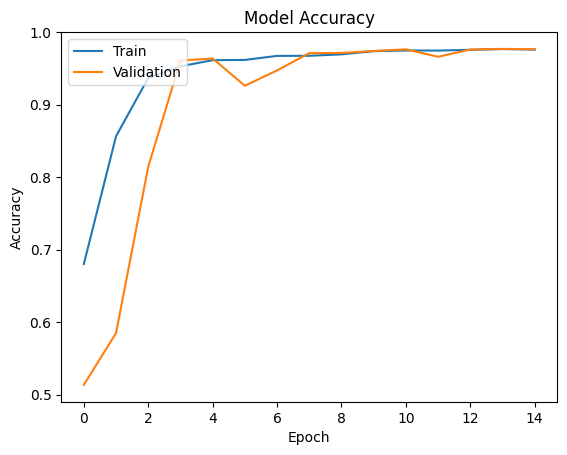

In [ ]:
trainvalcurve(history_4)

<B>Plotting the classification report and confusion matrix

82/82 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



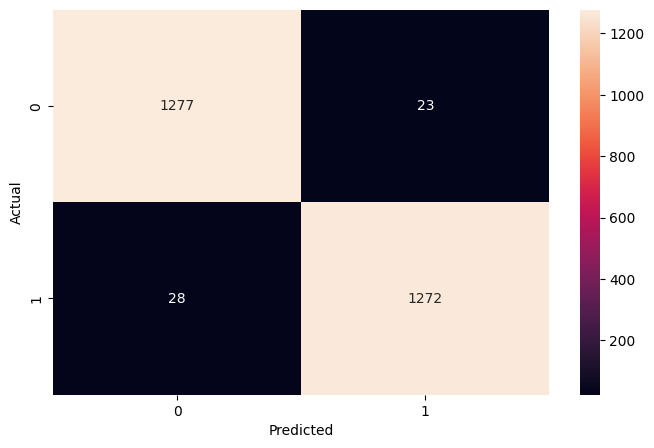

In [ ]:
y_pred_test, y_pred_test_classes, y_pred_test_max_probas = evaltest(test_images, model_4)

class_conf(test_labels, y_pred_test_classes)

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [ ]:
backend.clear_session()

np.random.seed(37)
random.seed(37)
tf.random.set_seed(37)

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights = 'imagenet',

                       include_top = False,

                       input_shape = (size, size, 3), pooling = 'max')

vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 80, 80, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 80, 80, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 40, 40, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 40, 40, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 40, 40, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 20, 128)       0     

In [ ]:
transfer_layer = vgg_model.get_layer('block3_pool')
vgg_model.trainable = False

# I don't want to re train the VGG layers.

In [ ]:
# Add classification layers on top of it

x = Flatten()(transfer_layer.output)
x = Dropout(0.3)(x)
x = Dense(32, activation = 'relu')(x)
x = BatchNormalization()(x)
pred = Dense(2, activation = 'softmax')(x)

# Initializing the model
model_5 = Model(vgg_model.input, pred)

###<b>Compiling the model

In [ ]:
model_5.compile(loss = 'binary_crossentropy',

              optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),

              metrics = ['accuracy'])

<b> using callbacks

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
model_5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 80, 80, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 80, 80, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 40, 40, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 40, 40, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 40, 40, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 20, 128)       0     

<b>Fit and Train the model

In [ ]:
history_5 = model_5.fit(
            x_train_normalized, y_train_encoded,
            epochs = epoch,
            validation_split = val,
            shuffle = True,
            batch_size=batch,
            use_multiprocessing = True,
            callbacks = [es, mc]
)

Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 0.3706 - accuracy: 0.8493
Epoch 1: val_accuracy improved from -inf to 0.70092, saving model to best_model.h5
67/67 [==============================] - 6s 55ms/step - loss: 0.3706 - accuracy: 0.8493 - val_loss: 0.7094 - val_accuracy: 0.7009
Epoch 2/15
66/67 [============================>.] - ETA: 0s - loss: 0.2247 - accuracy: 0.9264
Epoch 2: val_accuracy improved from 0.70092 to 0.89804, saving model to best_model.h5
67/67 [==============================] - 2s 31ms/step - loss: 0.2246 - accuracy: 0.9265 - val_loss: 0.2882 - val_accuracy: 0.8980
Epoch 3/15
65/67 [============================>.] - ETA: 0s - loss: 0.1730 - accuracy: 0.9465
Epoch 3: val_accuracy improved from 0.89804 to 0.95232, saving model to best_model.h5
67/67 [==============================] - 2s 31ms/step - loss: 0.1726 - accuracy: 0.9464 - val_loss: 0.1250 - val_accuracy: 0.9523
Epoch 4/15
67/67 [==============================] - ETA: 0s - loss: 0.142

<b>Plot the train and validation accuracy

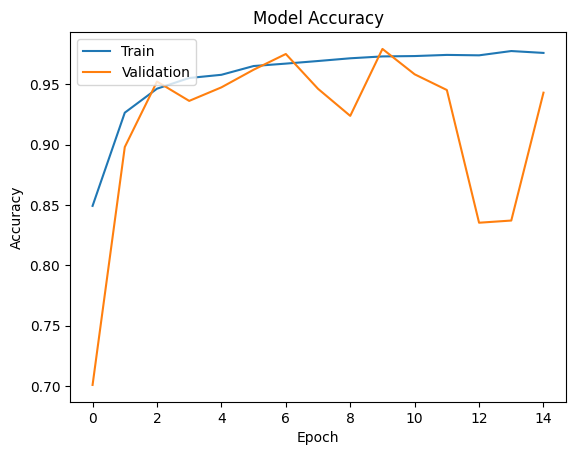

In [ ]:
trainvalcurve(history_5)


###**Observations and insights:**

*   The model is very accurate but from the training and validation curves it seem like it is not converging. Our previous models perform  better.

###<b> Evaluating the model

In [ ]:
y_pred_test, y_pred_test_classes, y_pred_test_max_probas = evaltest(x_test_normalized, model_5)


82/82 [==============================] - 1s 5ms/step


<b>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1300
           1       0.94      0.98      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



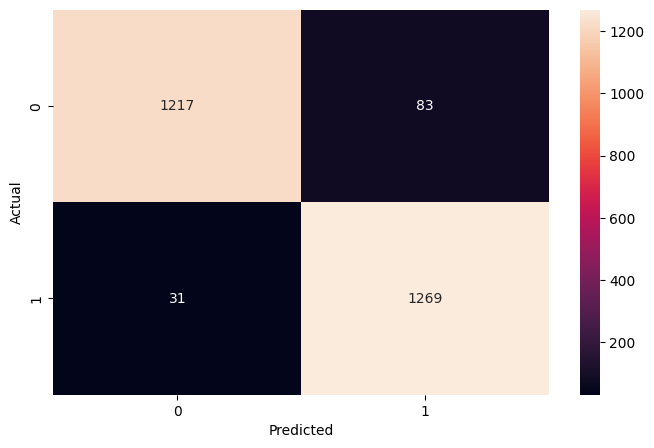

In [ ]:
class_conf(test_labels, y_pred_test_classes)

###<b>Model with HSV:</b>

* Now I look at the best model without Data Augmentation or VGG, but using HSV data instead of RGB. This because it seems like it is  easier to clasiffy infected cells when looking at those images.



In [ ]:
backend.clear_session()

np.random.seed(37)
random.seed(37)
tf.random.set_seed(37)

train_hgv = np.empty((train_images.shape[0], size,size,3), dtype=int)

for x in range(train_images.shape[0]):
  train_hgv[x] = cv2.cvtColor(train_images[x], cv2.COLOR_RGB2HSV)

test_hgv = np.empty((test_images.shape[0], size,size,3), dtype=int)

for x in range(test_images.shape[0]):
  test_hgv[x] = cv2.cvtColor(test_images[x], cv2.COLOR_RGB2HSV)



In [ ]:
def model_6():
  model = Sequential()
  model.add(Conv2D(filters = 16, kernel_size = 3, padding = "same", input_shape = (size, size, 3)))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))

  model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same'))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.3))

  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(2, activation = 'softmax'))

  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
    metrics=['accuracy']
    )


  return model

In [ ]:
model_6 = model_6()
print(model_6.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 16)        448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 40, 40, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                    

In [ ]:
history_6 = model_6.fit(
            train_hgv, y_train_encoded,
            epochs = epoch,
            validation_split = val,
            shuffle = True,
            batch_size=batch,
            use_multiprocessing = True,
            callbacks = [es, mc]
)

Epoch 1/15
66/67 [============================>.] - ETA: 0s - loss: 0.5393 - accuracy: 0.7366
Epoch 1: val_accuracy did not improve from 0.97937
67/67 [==============================] - 5s 35ms/step - loss: 0.5386 - accuracy: 0.7377 - val_loss: 8.6740 - val_accuracy: 0.0000e+00
Epoch 2/15
66/67 [============================>.] - ETA: 0s - loss: 0.2369 - accuracy: 0.9143
Epoch 2: val_accuracy did not improve from 0.97937
67/67 [==============================] - 2s 25ms/step - loss: 0.2363 - accuracy: 0.9146 - val_loss: 3.8663 - val_accuracy: 0.0088
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.9530
Epoch 3: val_accuracy did not improve from 0.97937
67/67 [==============================] - 2s 24ms/step - loss: 0.1379 - accuracy: 0.9530 - val_loss: 0.3300 - val_accuracy: 0.8938
Epoch 4/15
67/67 [==============================] - ETA: 0s - loss: 0.1113 - accuracy: 0.9613
Epoch 4: val_accuracy did not improve from 0.97937
67/67 [===================

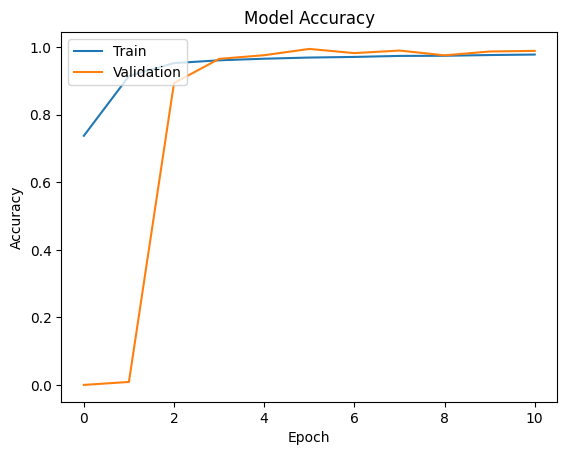

In [ ]:
trainvalcurve(history_6)

In [ ]:
y_pred_test, y_pred_test_classes, y_pred_test_max_probas = evaltest(test_hgv, model_6)


82/82 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



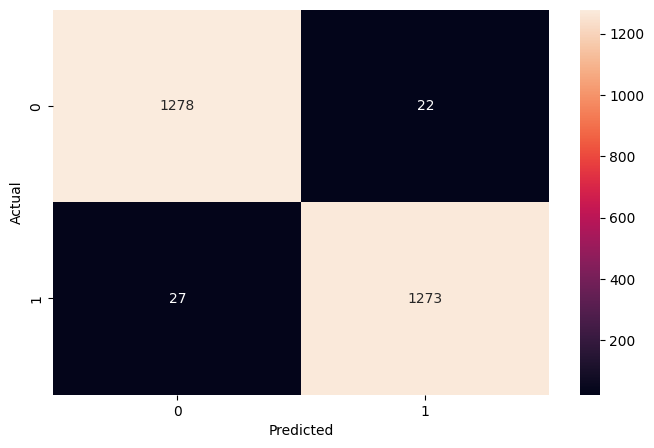

In [ ]:
class_conf(test_labels, y_pred_test_classes)

**Final Model**

For the final model I use HSV images and Data Augmentation, with the same architecture used before.

In [ ]:
backend.clear_session()

np.random.seed(37)
random.seed(37)
tf.random.set_seed(37)

x_train, x_val, y_train, y_val = train_test_split(train_hgv, y_train_encoded, test_size = val)

train_datagen = ImageDataGenerator( rotation_range=90, horizontal_flip=True )
#vertical and horizontal movement, and zoom do not produce good results. It probably has to do with the nature of the images.
val_datagen =ImageDataGenerator()

In [ ]:
it1 = train_datagen.flow(x_train, y_train, batch_size=100, seed = 37, shuffle = True)
it2 = val_datagen.flow(x_val, y_val, batch_size=100, seed = 37, shuffle = True)

In [ ]:
def model_7():
  model = Sequential()
  model.add(Conv2D(filters = 16, kernel_size = 3, padding = "same", input_shape = (size, size, 3)))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))

  model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 4))
  model.add(BatchNormalization())

  model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same'))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.3))

  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(2, activation = 'softmax'))

  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
    metrics=['accuracy']
    )


  return model

In [ ]:
model_7 = model_7()
print(model_7.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 16)        448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 40, 40, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                    

In [ ]:
np.random.seed(37)
random.seed(37)
tf.random.set_seed(37)

history_7 = model_7.fit(
            it1,
            validation_data = it2,
            epochs = epoch,
            batch_size=batch,
            steps_per_epoch=150,
            callbacks = [es, mc]
)


Epoch 1/15
150/150 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.8623
Epoch 1: val_accuracy improved from -inf to 0.60196, saving model to best_model.h5
150/150 [==============================] - 35s 161ms/step - loss: 0.3227 - accuracy: 0.8623 - val_loss: 0.7209 - val_accuracy: 0.6020
Epoch 2/15
150/150 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.9558
Epoch 2: val_accuracy improved from 0.60196 to 0.96434, saving model to best_model.h5
150/150 [==============================] - 24s 162ms/step - loss: 0.1334 - accuracy: 0.9558 - val_loss: 0.1077 - val_accuracy: 0.9643
Epoch 3/15
150/150 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9633
Epoch 3: val_accuracy did not improve from 0.96434
150/150 [==============================] - 24s 161ms/step - loss: 0.1107 - accuracy: 0.9633 - val_loss: 0.1019 - val_accuracy: 0.9641
Epoch 4/15
150/150 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0

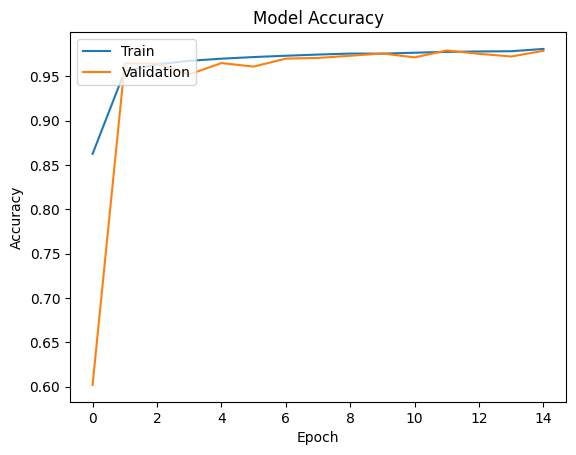

In [ ]:
trainvalcurve(history_7)

82/82 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1300
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



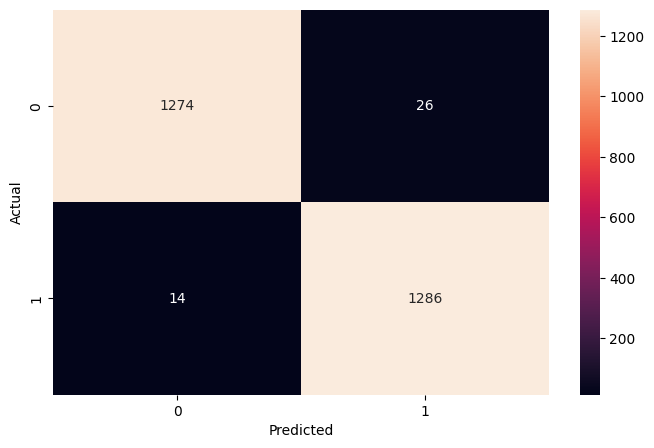

In [ ]:
y_pred_test, y_pred_test_classes, y_pred_test_max_probas = evaltest(test_hgv, model_7)
class_conf(test_labels, y_pred_test_classes)


**Comments:**

The recall improves slightly from the previous model. Now we are able to identify correctly 99% of the infected cells.

This is probably due to having more similarities between training and test samples when we do data augmentation, since it allows for more variations of the images.

### **Non detected infected cells:**

Now, I show some of the infected cells the model is not detecting, both as HSV and RGB images.

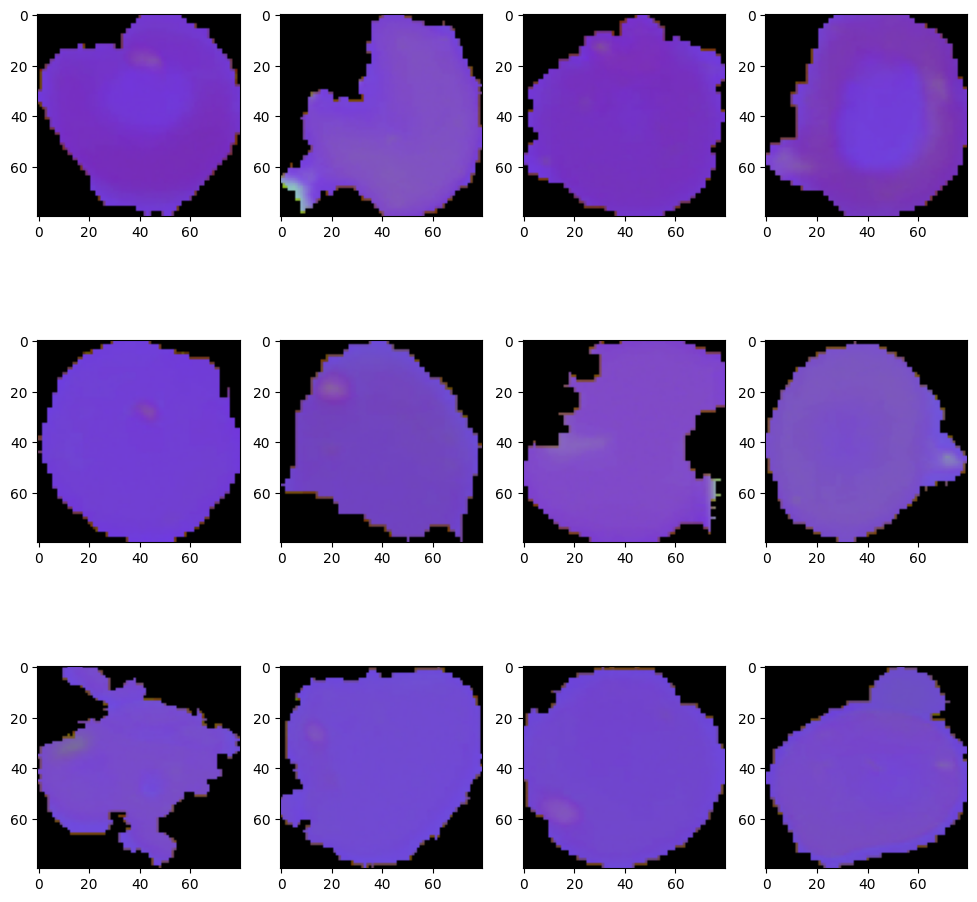

In [ ]:
cols2 = 4
rows2 = 3

fig = plt.figure(figsize = (12, 12))

for i in range(cols2):
      for j in range(rows2):
          ax = fig.add_subplot(rows2, cols2, i * rows2 + j + 1)
          ax.imshow(aux[i*rows2 + j].astype('uint8'))
plt.show()

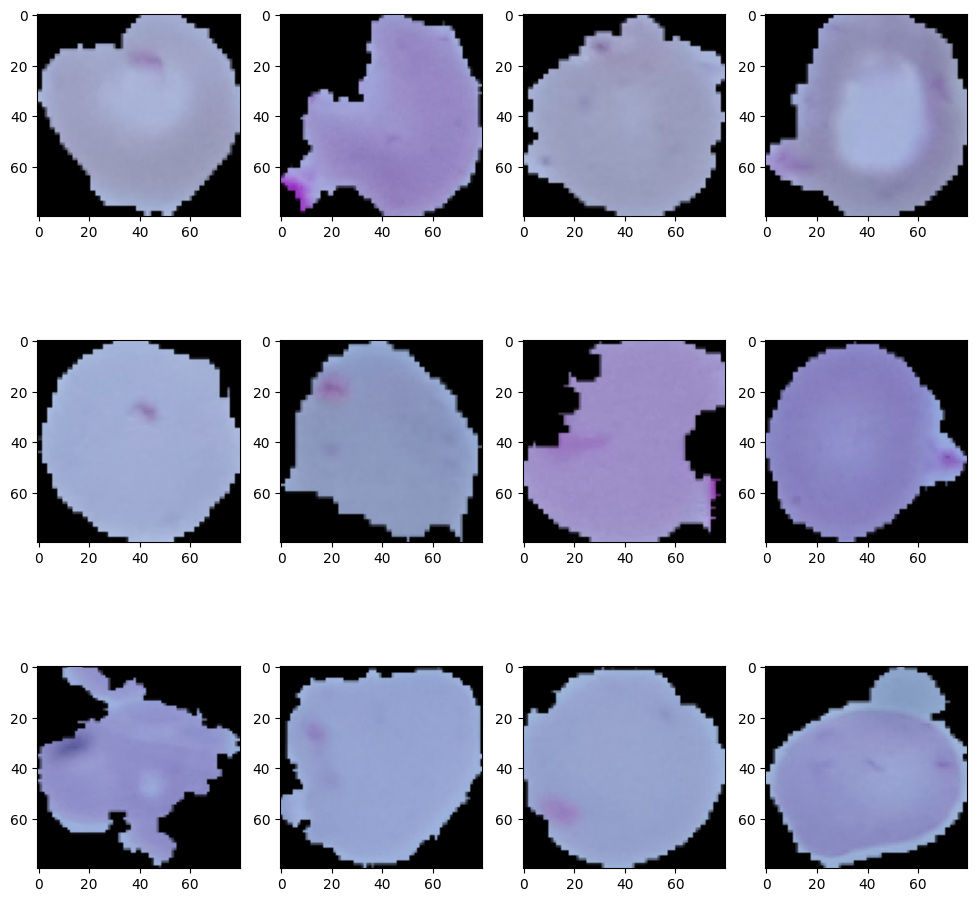

In [ ]:
aux = test_images[np.logical_and(test_labels == 1, y_pred_test_classes ==0) ]

cols2 = 4
rows2 = 3

fig = plt.figure(figsize = (12, 12))

for i in range(cols2):
      for j in range(rows2):
          ax = fig.add_subplot(rows2, cols2, i * rows2 + j + 1)
          ax.imshow(aux[i*rows2 + j].astype('uint8'))
plt.show()

The images show 12 out of 14 infected cells not detected. It looks like the model is not good at detecting infections that are close to the black part, and some that are more subtle. Given more time this problem could be addressed by modifying the architecture accordingly.

###<b>Final Comments:</b>
*  From the confusion matrix and classification report of this last model, it loook like it is the most accurate. More important, it performs very well asigning infected status to infected cells, which is what matters the most in this kind of applications. (It costs more not detecting someone with an infection than assigning infected status to someone healthy)


#### **Insights**

####**Refined insights**:
- The most meanigful insights from the data are that CNN seems to perform very good.

- Also, from playing around, it looks that some data augmentation techiques are not useful. Thes probably has to do with the fact that photos are taken in a controlled environment. Therefore, including zooms or horizontal/vertical movements agreggate noise to the images and make the techniques perform worse. This is important since in a real life situation we would need to prepare the images in a way it ressembles the ones used here.

- Afrter playing around with different resolutions, more complicated techniques, epochs, etc., it seems that there are little gains from doing that.


####**Comparison of various techniques and their relative performance**:
- As mentioned before, it seems there is little gain from complicating the model further. The performance is quite good with only 3 convolution layers.

- More over, even though there are many values that have to be calibrated, as batch, size of the image, epoch, etc. Results (not shown here) do not vary much.

- In this case, using a simple model with HSV images and Data Augmentation gives the best performance, but is not far from the results with only HSV, or with standarized RGB and Data Augmentation. Again, this is probably due to the nature of the problem and how the input data was prepared.


####**Final solution design**:
- For the final solution my design includes Data Augemtation as given here, the CNN architecture of model3 (last model without advanced techniques), and the use of HSV images, with some calibration of the parameters.